# **Loading data and packages**

**Libraries import**

In [3]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from ipywidgets import interact
import ipywidgets as widgets
from joblib import load, dump

from sklearn.model_selection import (
    train_test_split, LeaveOneOut, cross_validate, learning_curve, cross_val_predict
)
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    make_scorer, confusion_matrix, classification_report, roc_curve, auc
)
from sklearn.ensemble import (
    ExtraTreesClassifier, RandomForestClassifier,
    AdaBoostClassifier, GradientBoostingClassifier
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.datasets import make_classification
from sklearn.feature_selection import SelectKBest, f_classif

from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.metrics import geometric_mean_score

import os
import pandas as pd
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import interact
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import RandomOverSampler, ADASYN
from imblearn.under_sampling import RandomUnderSampler, TomekLinks

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ipywidgets as widgets
from IPython.display import display
from imblearn.over_sampling import SMOTENC



**Data import**

In [4]:
# Definindo variáveis globais para armazenar o DataFrame e o nome do dataset
df = pd.DataFrame()
dataset_name = None
X = None
y = None
balancing_method_selected = None  # Variável global para armazenar o método de balanceamento selecionado

# Função para listar arquivos CSV no diretório
def list_csv_files(directory):
    return [f for f in os.listdir(directory) if f.endswith('.csv')]

# Função para carregar e processar o dataset selecionado
def load_and_process_data(selected_file):
    global df, dataset_name, X, y
    dataset_name = selected_file
    file_path = os.path.join('..', 'datasets', 'feature_selection', dataset_name)

    if not os.path.exists(file_path):
        print(f"Erro: O arquivo '{file_path}' não foi encontrado.")
        return None

    df = pd.read_csv(file_path)

    # Convertendo 'Gênero' para valores numéricos
    if 'Gênero' in df.columns:
        df['Gênero'] = df['Gênero'].replace({'M': 0, 'F': 1})

    # Normalizando 'Idade_clinica'
    if 'Idade_clinica' in df.columns:
        scaler = MinMaxScaler()
        df['Idade_clinica'] = scaler.fit_transform(df[['Idade_clinica']])

    # Definindo X (features) e y (target)
    X = df.drop(columns=['PROVAVEL_HAM/TSP']) 
    y = df['PROVAVEL_HAM/TSP'] 

    print(f"Data Loaded and Processed Successfully! Dataset: {dataset_name}")
    return df.head()

# Função para definir o método de balanceamento selecionado
def set_balancing_method(method):
    global balancing_method_selected  # Declarando a variável como global
    balancing_method_selected = method  # Atribui o método selecionado à variável
    print(f"Método de balanceamento selecionado: {balancing_method_selected}")

# Função para aplicar o método de balanceamento selecionado
def apply_balancing(X, y):
    global balancing_method_selected
    if balancing_method_selected is None:
        print("Nenhum método de balanceamento foi selecionado.")
        return X, y

    if balancing_method_selected == 'Random Over Sampler':
        balancer = RandomOverSampler(random_state=42)
    elif balancing_method_selected == 'SMOTENC':
        # Ajusta dinamicamente as colunas categóricas para o SMOTENC
        categorical_columns = [col for col in X.columns if col != 'Idade_clinica']
        categorical_features = [X.columns.get_loc(col) for col in categorical_columns]
        balancer = SMOTENC(categorical_features=categorical_features, random_state=42)
    elif balancing_method_selected == 'Random Under Sampler':
        balancer = RandomUnderSampler(random_state=42)
    elif balancing_method_selected == 'Tomek Links':
        balancer = TomekLinks()
    else:
        print(f"Método de balanceamento desconhecido: {balancing_method_selected}")
        return X, y

    # Aplicando o método de balanceamento
    X_res, y_res = balancer.fit_resample(X, y)
    #print(f"Balanceamento aplicado com sucesso usando: {balancing_method_selected}")
    return X_res, y_res

# Definir o diretório onde os arquivos CSV estão localizados
directory = '..\\datasets\\feature_selection\\'

# Listar os arquivos CSV disponíveis no diretório
csv_files = list_csv_files(directory)

# Criar um widget de seleção com os arquivos listados
file_selector = widgets.Dropdown(
    options=csv_files,
    description='Select File:'
)

# Criar um widget para selecionar o método de balanceamento
balancing_methods = ['Random Over Sampler', 'SMOTENC', 'Random Under Sampler', 'Tomek Links']
method_selector = widgets.Dropdown(
    options=balancing_methods,
    description='Balancing Method:'
)

# Função interativa para carregar e processar o arquivo CSV selecionado
@interact(selected_file=file_selector)
def load_and_process_selected_file(selected_file):
    return load_and_process_data(selected_file)

# Função interativa para aplicar o método de balanceamento selecionado
@interact(selected_method=method_selector)
def apply_selected_balancing_method(selected_method):
    set_balancing_method(selected_method)
    X_res, y_res = apply_balancing(X, y)  # Aplica o balanceamento aos dados carregados
    print(f"Shape dos dados balanceados: {X_res.shape}, {y_res.shape}")


interactive(children=(Dropdown(description='Select File:', options=('df_Clinic_dataset_cat_1_ADA.csv', 'df_Cli…

interactive(children=(Dropdown(description='Balancing Method:', options=('Random Over Sampler', 'SMOTENC', 'Ra…

#  **Definition of variables, models and metrics**

**Define the variables (X and y) and classifiers** 

In [5]:
# List of model names that have been adjusted
model_names = ['DT', 'GB', 'LR', 'MLP', 'NB', 'RF', 'SVM', 'KNN', 'AB', 'LSVM']

# Directory where models and results are saved
model_dir = '..\\models\\'

# Dictionary to store loaded templates
classifiers = {}

# Function for loading templates
def load_model(model_name):
    model_path = os.path.join(model_dir, f'best_{model_name}_model.joblib')

    if os.path.exists(model_path):
        # Load the model
        model = load(model_path)

        
        if isinstance(model, SVC):
            model.probability = True

        # Add the model to the classifiers dictionary using the corresponding name
        classifiers[model_name] = model

        print(f'Modelo {model_name} carregado com sucesso.')
    else:
        print(f'Arquivo para o modelo {model_name} não encontrado.')

# Iterate over all the model names and load them
for model_name in model_names:
    load_model(model_name)

Modelo DT carregado com sucesso.
Modelo GB carregado com sucesso.
Modelo LR carregado com sucesso.
Modelo MLP carregado com sucesso.
Modelo NB carregado com sucesso.
Modelo RF carregado com sucesso.
Modelo SVM carregado com sucesso.
Modelo KNN carregado com sucesso.
Modelo AB carregado com sucesso.
Modelo LSVM carregado com sucesso.


In [6]:
print(balancing_method_selected)

SMOTENC


# **Model evaluation**

Generation of the results

In [11]:
import numpy as np
import pandas as pd
from sklearn.model_selection import LeaveOneOut, cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from imblearn.metrics import geometric_mean_score
from imblearn.pipeline import Pipeline  # Importar Pipeline do imblearn
from imblearn.over_sampling import RandomOverSampler, SMOTENC
from imblearn.under_sampling import RandomUnderSampler, TomekLinks

# Lista para armazenar os resultados
results = []

# Definir a estratégia Leave-One-Out
loo = LeaveOneOut()

# Função para aplicar o método de balanceamento selecionado
def get_balancing_method():
    global balancing_method_selected
    if balancing_method_selected == 'Random Over Sampler':
        return RandomOverSampler(random_state=42)
    elif balancing_method_selected == 'SMOTENC':
        # Definir as colunas categóricas para SMOTENC
        categorical_columns = [col for col in X.columns if col != 'Idade_clinica']  # Ajuste conforme seu dataset
        categorical_features = [X.columns.get_loc(col) for col in categorical_columns]
        return SMOTENC(categorical_features=categorical_features, random_state=42)
    elif balancing_method_selected == 'Random Under Sampler':
        return RandomUnderSampler(random_state=42)
    elif balancing_method_selected == 'Tomek Links':
        return TomekLinks()
    else:
        print("Nenhum método de balanceamento válido selecionado.")
        return None

# Iterando sobre os classificadores
for clf_name, clf in classifiers.items():
    
    # Obtendo o método de balanceamento selecionado
    balancing_method = get_balancing_method()
    
    if balancing_method is None:
        print(f"Erro: Nenhum método de balanceamento válido para o classificador {clf_name}. Pulando este classificador.")
        continue

    # Definir o pipeline usando o Pipeline do imblearn
    pipeline = Pipeline([
        ('balancing', balancing_method),  # Balanceamento usando método selecionado
        ('classifier', clf)  # Classificador
    ])
    
    # Realizar as previsões com Leave-One-Out
    y_pred = cross_val_predict(pipeline, X, y, cv=loo)
    
    # Tratando classificadores que não suportam `predict_proba`
    try:
        y_prob = cross_val_predict(pipeline, X, y, cv=loo, method='predict_proba')[:, 1]
    except AttributeError:
        if hasattr(clf, "decision_function"):
            y_prob = cross_val_predict(pipeline, X, y, cv=loo, method='decision_function')
            # Normalizando para o intervalo [0, 1]
            y_prob = (y_prob - y_prob.min()) / (y_prob.max() - y_prob.min())
        else:
            y_prob = np.zeros_like(y_pred)  # Caso o classificador não tenha `predict_proba` ou `decision_function`

    # Calcular as métricas de teste
    test_scores = {
        'classifier': clf_name,
        'Accuracy': accuracy_score(y, y_pred),
        'Precision': precision_score(y, y_pred),
        'Recall': recall_score(y, y_pred),
        'F1': f1_score(y, y_pred),
        'ROC AUC': roc_auc_score(y, y_prob),
        'G-Mean': geometric_mean_score(y, y_pred)
    }

    # Adicionar à lista de resultados
    results.append(test_scores)

# Converter a lista de resultados para um DataFrame
results_df = pd.DataFrame(results)

# Exibir o DataFrame de resultados
print(results_df)


c:\Users\mathe\anaconda3\envs\ML-2024python3_11_\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\mathe\anaconda3\envs\ML-2024python3_11_\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\mathe\anaconda3\envs\ML-2024python3_11_\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\mathe\anaconda3\envs\ML-2024python3_11_\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning

  classifier  Accuracy  Precision    Recall        F1   ROC AUC    G-Mean
0         DT  0.785714   1.000000  0.125000  0.222222  0.541667  0.353553
1         GB  0.632653   0.285714  0.333333  0.307692  0.529842  0.493197
2         LR  0.510204   0.200000  0.333333  0.250000  0.422297  0.434959
3        MLP  0.755102   0.000000  0.000000  0.000000  0.180180  0.000000
4         NB  0.469388   0.208333  0.416667  0.277778  0.350225  0.450225
5         RF  0.500000   0.037037  0.041667  0.039216  0.422297  0.164399
6        SVM  0.704082   0.142857  0.041667  0.064516  0.802365  0.195674
7        KNN  0.602041   0.285714  0.416667  0.338983  0.521115  0.525263
8         AB  0.663265   0.354839  0.458333  0.400000  0.594032  0.578325
9       LSVM  0.530612   0.238095  0.416667  0.303030  0.451577  0.486299


Heatmap plot

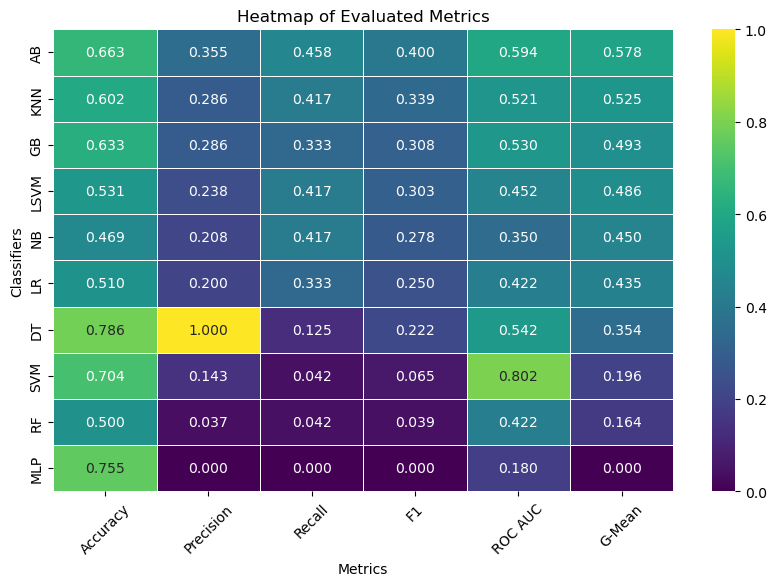

In [12]:
# Definindo os nomes das métricas de avaliação
metric_names = ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC AUC', 'G-Mean']

# Selecionando as métricas para o heatmap e configurando o índice
heatmap_df = results_df[metric_names].set_index(results_df['classifier'])

# Ordenando o DataFrame pelo valor do G-Mean
heatmap_df = heatmap_df.sort_values(by='G-Mean', ascending=False)

# Plotando o heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_df, cmap='viridis', annot=True, fmt=".3f", linewidths=.5)
plt.title('Heatmap of Evaluated Metrics')
plt.xlabel('Metrics')
plt.ylabel('Classifiers')
plt.xticks(rotation=45)
plt.savefig('..\\results\\heatmap.jpeg')
plt.show()


Polar plot

Dropdown(description='Modelo 1', options=('GB', 'LR', 'MLP', 'SVM', 'LSVM', 'DT', 'RF', 'NB', 'AB', 'KNN'), va…

Dropdown(description='Modelo 2', index=1, options=('GB', 'LR', 'MLP', 'SVM', 'LSVM', 'DT', 'RF', 'NB', 'AB', '…

Dropdown(description='Modelo 3', index=2, options=('GB', 'LR', 'MLP', 'SVM', 'LSVM', 'DT', 'RF', 'NB', 'AB', '…

Dropdown(description='Modelo 4', index=3, options=('GB', 'LR', 'MLP', 'SVM', 'LSVM', 'DT', 'RF', 'NB', 'AB', '…

Button(description='Gerar Gráfico', style=ButtonStyle())

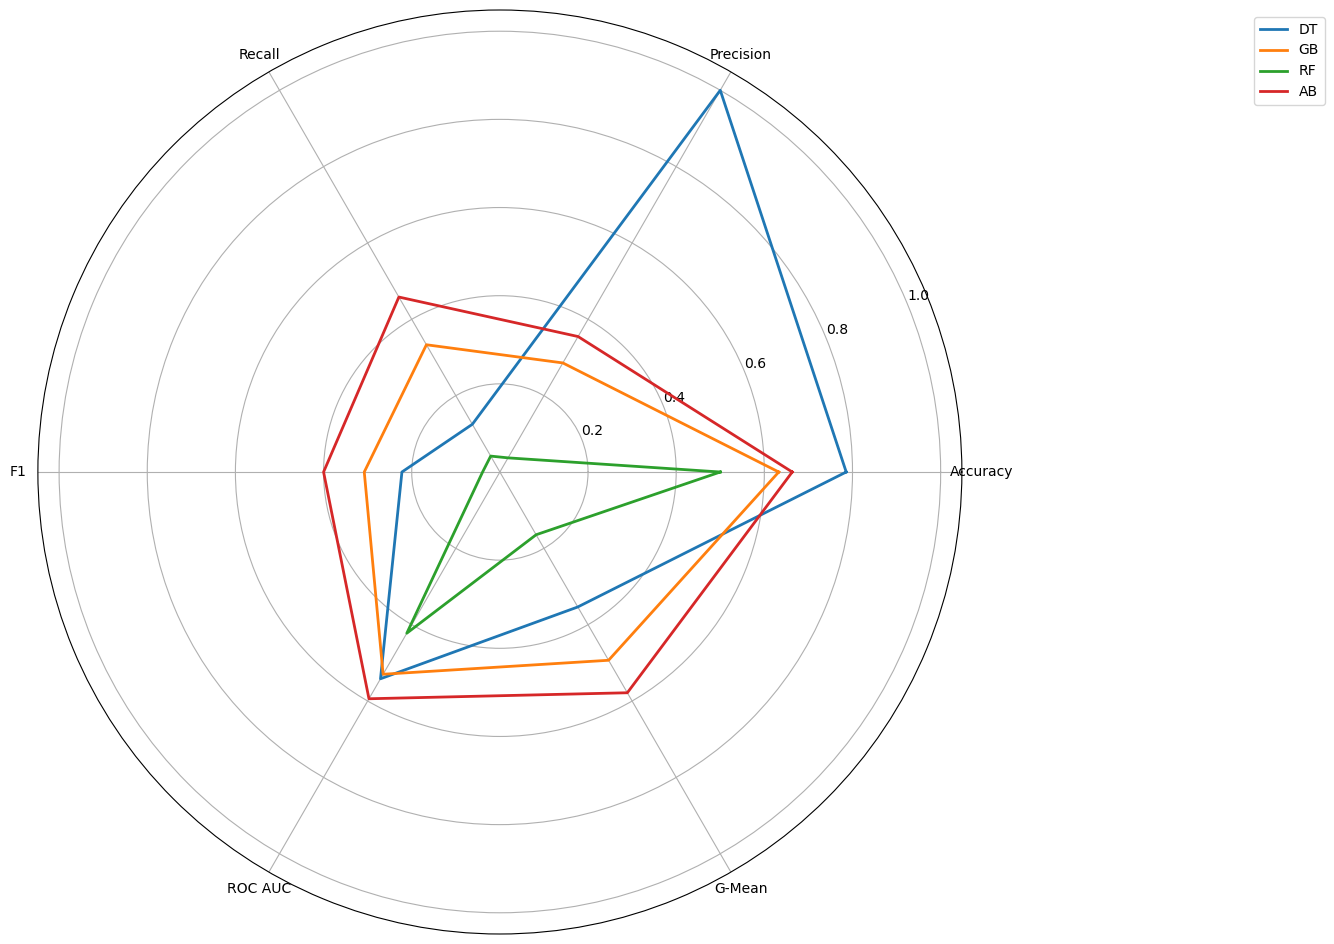

Gráfico salvo em: ..\results\polar_plot.jpeg


In [13]:
# Definir os classificadores disponíveis
available_models = ['GB', 'LR', 'MLP', 'SVM', 'LSVM', 'DT', 'RF', 'NB', 'AB', 'KNN']

# Widgets de seleção de modelo
model_selector_1 = widgets.Dropdown(options=available_models, description='Modelo 1', value=available_models[0])
model_selector_2 = widgets.Dropdown(options=available_models, description='Modelo 2', value=available_models[1])
model_selector_3 = widgets.Dropdown(options=available_models, description='Modelo 3', value=available_models[2])
model_selector_4 = widgets.Dropdown(options=available_models, description='Modelo 4', value=available_models[3])

# Exibir os widgets para o usuário
display(model_selector_1, model_selector_2, model_selector_3, model_selector_4)
def plot_selected_models(results_df):
    # Obtenha os modelos selecionados nos dropdowns
    selected_models = [model_selector_1.value, model_selector_2.value, model_selector_3.value, model_selector_4.value]

    # Verifique se há duplicatas nos modelos selecionados
    if len(selected_models) != len(set(selected_models)):
        print("Por favor, selecione modelos diferentes em cada widget.")
        return

    # Filtrar os resultados para os modelos selecionados
    results_df_filtered = results_df[results_df['classifier'].isin(selected_models)]

    # Criando a figura para o gráfico polar
    fig, ax = plt.subplots(figsize=(12, 12), subplot_kw={'projection': 'polar'})

    # Iterar sobre cada linha do DataFrame filtrado e plotar as métricas no gráfico polar
    for i, row in results_df_filtered.iterrows():
        # Pegar as métricas em ordem
        metrics = [row['Accuracy'], row['Precision'], row['Recall'], row['F1'], row['ROC AUC'], row['G-Mean']]
        
        # Conectar o primeiro valor ao último para fechar o gráfico
        metrics.append(metrics[0])
        
        # Definir os ângulos (de 0 a 2π) e plotar no gráfico polar
        angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=True)
        ax.plot(angles, metrics, label=row['classifier'], linewidth=2)

    # Configurando os rótulos dos eixos
    ax.set_xticks(np.linspace(0, 2*np.pi, 6, endpoint=False))
    ax.set_xticklabels(['Accuracy', 'Precision', 'Recall', 'F1', 'ROC AUC', 'G-Mean'])

    # Adicionar uma legenda fora do gráfico
    ax.legend(loc='upper right', bbox_to_anchor=(1.4, 1))

    # Definir as cores do gráfico
    ax.set_prop_cycle(color=plt.cm.viridis(np.linspace(0, 1, len(results_df_filtered))))

    # Exibir o gráfico
    plt.show()

    # Salvar o gráfico na pasta ../results/
    save_path = '..\\results\\polar_plot.jpeg'
    fig.savefig(save_path, bbox_inches='tight')
    print(f"Gráfico salvo em: {save_path}")
    
# Criar botão para plotar o gráfico
plot_button = widgets.Button(description="Gerar Gráfico")

# Função para ser executada quando o botão for clicado
def on_plot_button_clicked(b):
    plot_selected_models(results_df)

# Vincular a função ao botão
plot_button.on_click(on_plot_button_clicked)

# Exibir o botão
display(plot_button)


Bar graph comparation plot

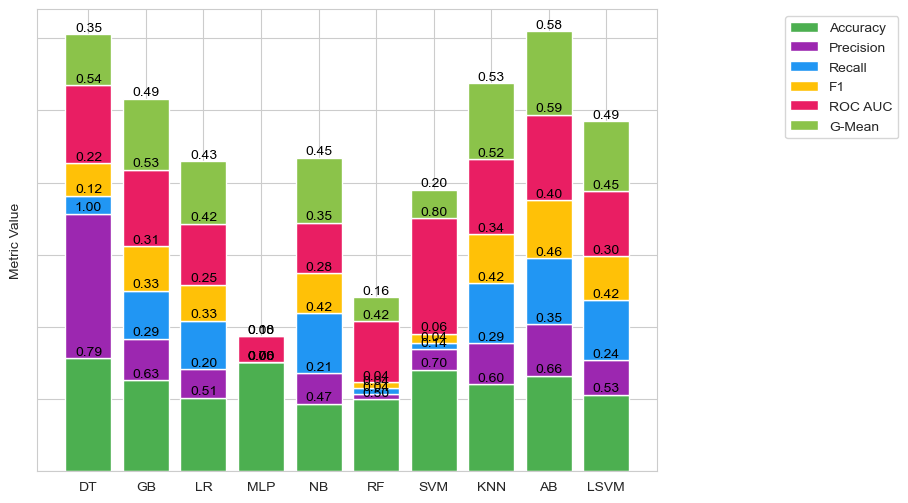

Gráfico salvo em: ../results/bar_plot_all_models.png


In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Configurar o estilo do seaborn
sns.set_style("whitegrid")

# Criar a figura
fig, ax = plt.subplots(figsize=(8, 6))

# Criar barras para cada métrica
bars = ax.bar(range(len(results_df)), results_df['Accuracy'], label='Accuracy', color='#4CAF50')  # Green
for i, (bar, value) in enumerate(zip(bars, results_df['Accuracy'])):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f"{value:.2f}", ha='center', va='bottom', color='black')

bars = ax.bar(range(len(results_df)), results_df['Precision'], bottom=results_df['Accuracy'], label='Precision', color='#9C27B0')  # Purple
for i, (bar, value) in enumerate(zip(bars, results_df['Precision'])):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + results_df['Accuracy'].iloc[i], f"{value:.2f}", ha='center', va='bottom', color='black')

bars = ax.bar(range(len(results_df)), results_df['Recall'], bottom=results_df['Accuracy'] + results_df['Precision'], label='Recall', color='#2196F3')  # Blue
for i, (bar, value) in enumerate(zip(bars, results_df['Recall'])):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + (results_df['Accuracy'] + results_df['Precision']).iloc[i], f"{value:.2f}", ha='center', va='bottom', color='black')

bars = ax.bar(range(len(results_df)), results_df['F1'], bottom=results_df['Accuracy'] + results_df['Precision'] + results_df['Recall'], label='F1', color='#FFC107')  # Yellow
for i, (bar, value) in enumerate(zip(bars, results_df['F1'])):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + (results_df['Accuracy'] + results_df['Precision'] + results_df['Recall']).iloc[i], f"{value:.2f}", ha='center', va='bottom', color='black')

bars = ax.bar(range(len(results_df)), results_df['ROC AUC'], bottom=results_df['Accuracy'] + results_df['Precision'] + results_df['Recall'] + results_df['F1'], label='ROC AUC', color='#E91E63')  # Pink
for i, (bar, value) in enumerate(zip(bars, results_df['ROC AUC'])):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + (results_df['Accuracy'] + results_df['Precision'] + results_df['Recall'] + results_df['F1']).iloc[i], f"{value:.2f}", ha='center', va='bottom', color='black')

bars = ax.bar(range(len(results_df)), results_df['G-Mean'], bottom=results_df['Accuracy'] + results_df['Precision'] + results_df['Recall'] + results_df['F1'] + results_df['ROC AUC'], label='G-Mean', color='#8BC34A')  # Light Green
for i, (bar, value) in enumerate(zip(bars, results_df['G-Mean'])):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + (results_df['Accuracy'] + results_df['Precision'] + results_df['Recall'] + results_df['F1'] + results_df['ROC AUC']).iloc[i], f"{value:.2f}", ha='center', va='bottom', color='black')

# Configurações do gráfico
ax.set_xticks(range(len(results_df)))
ax.set_yticklabels([])
ax.set_xticklabels(results_df['classifier'])
ax.set_ylabel('Metric Value')
ax.legend(loc='upper right', bbox_to_anchor=(1.4, 1))

# Exibir o gráfico
plt.show()

# Salvar o gráfico na pasta ../results/
save_path = '../results/bar_plot_all_models.png'
fig.savefig(save_path, bbox_inches='tight')
print(f"Gráfico salvo em: {save_path}")


Learning Curves

In [15]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np
import os
from imblearn.pipeline import Pipeline

def plot_learning_curve(X, y, classifiers, balancing_method, train_sizes=np.linspace(0.1, 1.0, 10)):
    results_dir = '..\\results\\'
    
    # Certifique-se de que o diretório de resultados existe
    if not os.path.exists(results_dir):
        os.makedirs(results_dir)

    for name, clf in classifiers.items():
        # Definindo o pipeline
        pipeline = Pipeline([
            ('balancing', balancing_method),  # Balanceamento usando método selecionado
            ('classifier', clf)  # Classificador
        ])
        
        # Calculando as curvas de aprendizado
        train_sizes_abs, train_scores, test_scores = learning_curve(
            pipeline, X, y, train_sizes=train_sizes, cv=loo, scoring='accuracy', n_jobs=-1
        )

        # Calculando as médias e desvios padrão das pontuações de treinamento e teste
        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)

        # Plotando as curvas de aprendizado
        plt.figure()
        plt.title(f'Curva de Aprendizado - {name}')
        plt.xlabel("Amostras de Treinamento")
        plt.ylabel("Acurácia")

        plt.plot(train_sizes_abs, train_scores_mean, 'o-', color="r", label="Pontuação de Treinamento")
        plt.plot(train_sizes_abs, test_scores_mean, 'o-', color="g", label="Pontuação de Teste")

        # Preenchendo as áreas de erro
        plt.fill_between(train_sizes_abs, 
                         train_scores_mean - train_scores_std, 
                         train_scores_mean + train_scores_std, 
                         alpha=0.1, color="r")
        plt.fill_between(train_sizes_abs, 
                         test_scores_mean - test_scores_std, 
                         test_scores_mean + test_scores_std, 
                         alpha=0.1, color="g")

        plt.legend(loc="best")
        plt.grid(True)
        
        # Salvando a plotagem
        plot_filename = os.path.join(results_dir, f'curva_aprendizado_{name}.png')
        plt.savefig(plot_filename)
        plt.close()  # Fecha a figura após salvar

# Exemplo de chamada da função
# Substitua `balancing_method` pelo método de balanceamento desejado
plot_learning_curve(X, y, classifiers, balancing_method)


c:\Users\mathe\anaconda3\envs\ML-2024python3_11_\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
392 fits failed out of a total of 980.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
8 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\mathe\anaconda3\envs\ML-2024python3_11_\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\mathe\anaconda3\envs\ML-2024python3_11_\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\mathe\anaconda3\envs\ML-2024p

In [50]:
print(balancing_method)

RandomUnderSampler(random_state=42)


Confusion matrix with LOOCV and balancing method to prediction, but just the original samples in the plot

Método de balanceamento desconhecido: SMOTENC
Predicted labels distribution for DT: [95  3]


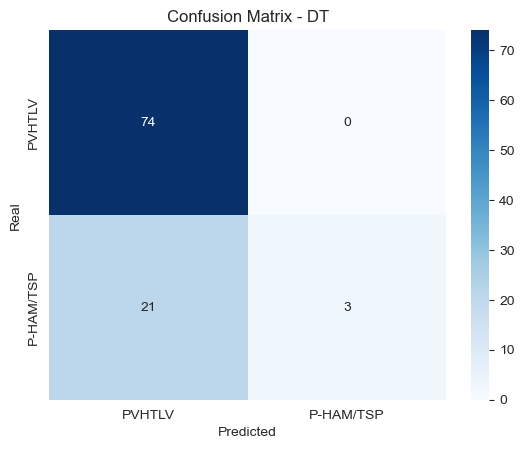

Método de balanceamento desconhecido: SMOTENC
Predicted labels distribution for GB: [70 28]


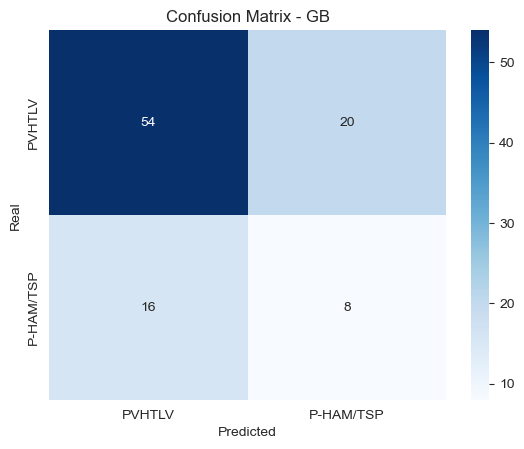

Método de balanceamento desconhecido: SMOTENC
Predicted labels distribution for LR: [58 40]


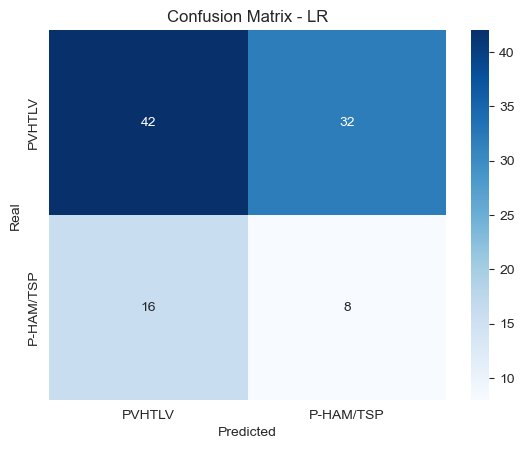

Método de balanceamento desconhecido: SMOTENC
Predicted labels distribution for MLP: [98]


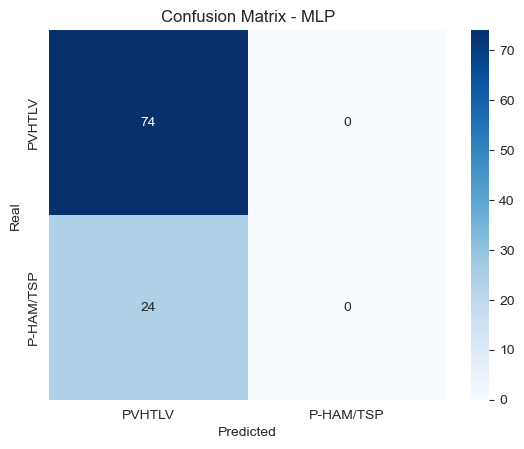

Método de balanceamento desconhecido: SMOTENC
Predicted labels distribution for NB: [50 48]


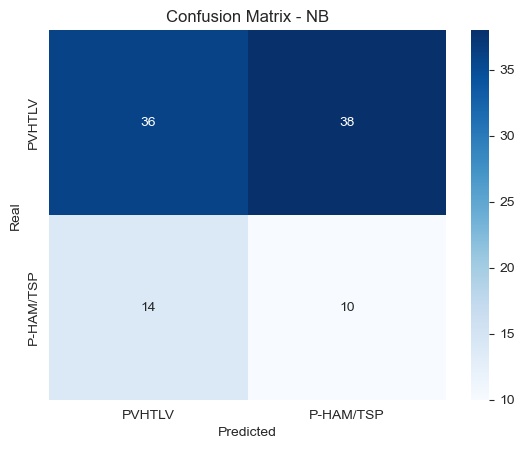

Método de balanceamento desconhecido: SMOTENC
Predicted labels distribution for RF: [71 27]


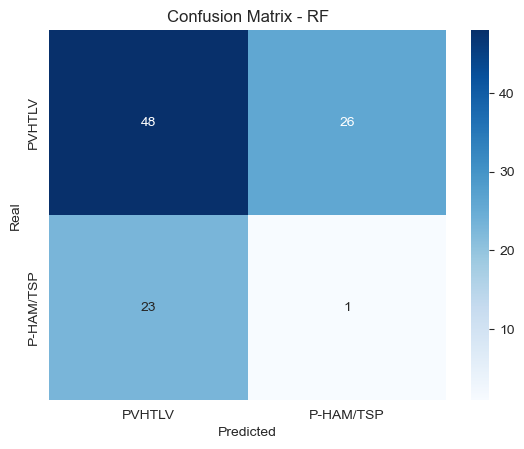

Método de balanceamento desconhecido: SMOTENC
Predicted labels distribution for SVM: [91  7]


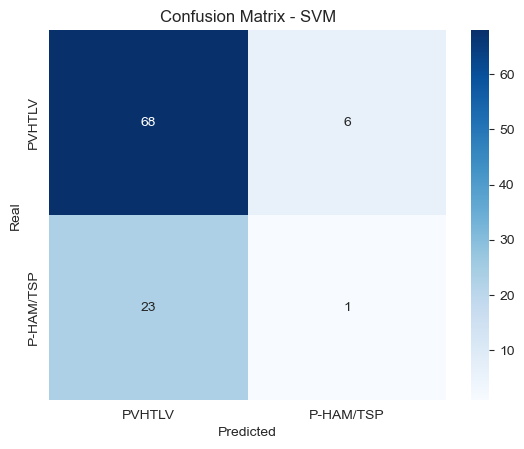

Método de balanceamento desconhecido: SMOTENC
Predicted labels distribution for KNN: [63 35]


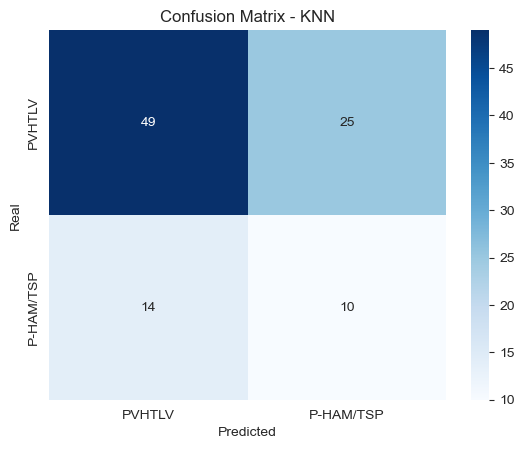

Método de balanceamento desconhecido: SMOTENC


c:\Users\mathe\anaconda3\envs\ML-2024python3_11_\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\mathe\anaconda3\envs\ML-2024python3_11_\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\mathe\anaconda3\envs\ML-2024python3_11_\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\mathe\anaconda3\envs\ML-2024python3_11_\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be r

Predicted labels distribution for AB: [67 31]


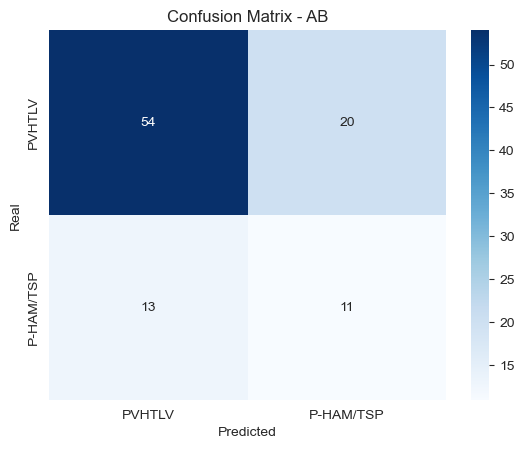

Método de balanceamento desconhecido: SMOTENC


c:\Users\mathe\anaconda3\envs\ML-2024python3_11_\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\mathe\anaconda3\envs\ML-2024python3_11_\Lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\mathe\anaconda3\envs\ML-2024python3_11_\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\mathe\anaconda3\envs\ML-2024python3_11_\Lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\mathe\anaconda3\envs\ML-2024python3_11_\Lib\site-packages\sklearn\svm\_classes.py

Predicted labels distribution for LSVM: [56 42]


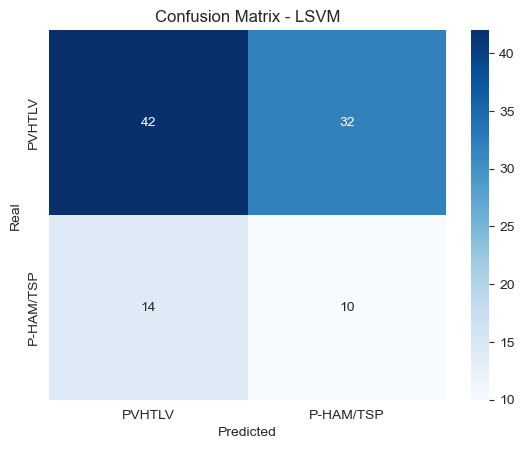

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix
from imblearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_predict

def get_balancing_method():
    global balancing_method_selected
    if balancing_method_selected == 'Random Over Sampler':
        return RandomOverSampler(random_state=42)
    elif balancing_method_selected == 'ADASYN':
        return ADASYN(random_state=42)
    elif balancing_method_selected == 'Random Under Sampler':
        return RandomUnderSampler(random_state=42)
    elif balancing_method_selected == 'Tomek Links':
        return TomekLinks()
    else:
        print(f"Método de balanceamento desconhecido: {balancing_method_selected}")
        return None

def plot_confusion_matrix(model_name):
    # Select the model
    model = classifiers[model_name]

    # Get the balancing method
    balancing_method = get_balancing_method()

    # Define the pipeline using the balancing method and the classifier
    pipeline = Pipeline([
        ('balancing', balancing_method),  # Balanceamento usando método selecionado
        ('classifier', model)  # Classificador
    ])
    
    # Making predictions using cross_val_predict with the pipeline
    y_preds = cross_val_predict(pipeline, X, y, cv=loo)

    # Calculate the confusion matrix
    cm = confusion_matrix(y, y_preds) 
    
    # Print the predicted labels distribution for debugging
    print(f"Predicted labels distribution for {model_name}: {np.bincount(y_preds)}")
    
    # Define custom labels
    labels = ['PVHTLV', 'P-HAM/TSP']

    # Plot the heat map
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Real')
    plt.title(f'Confusion Matrix - {model_name}')
    
    # Save the picture
    plt.savefig(f'../results/{model_name}_confusion_matrix.jpeg')
    plt.show()

# Iterating over each model in classifiers
for model_name in classifiers:
    plot_confusion_matrix(model_name)


Confunsion matrix with the balancing method in the plot

Predicted labels distribution for DT: [148]


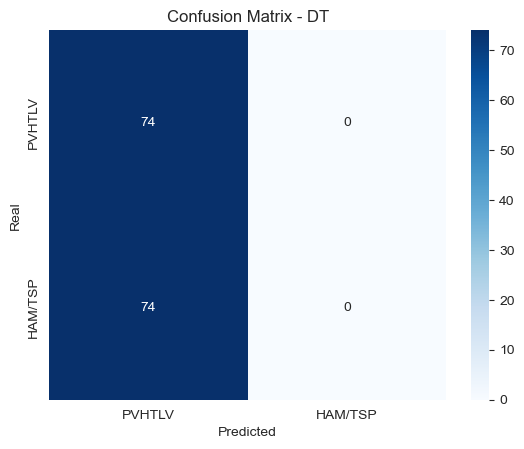

Predicted labels distribution for GB: [73 75]


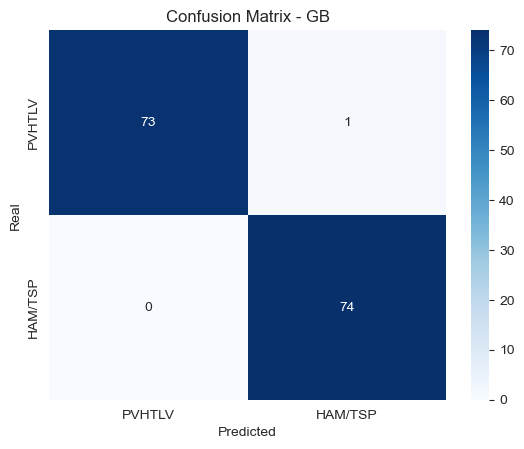

Predicted labels distribution for LR: [95 53]


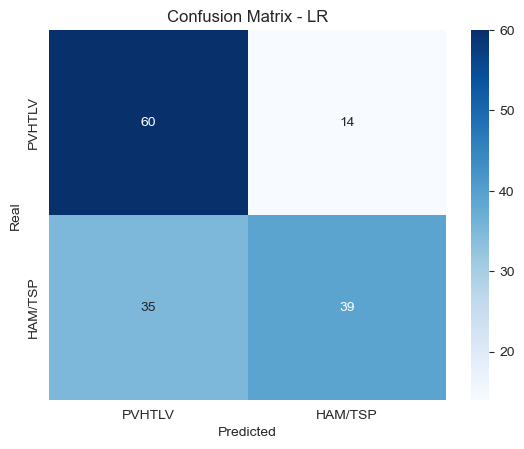

Predicted labels distribution for MLP: [73 75]


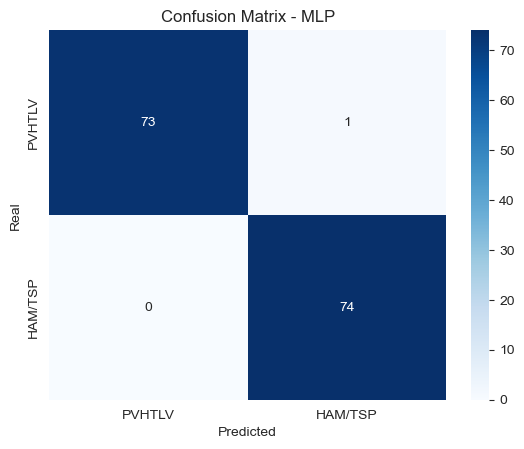

Predicted labels distribution for NB: [94 54]


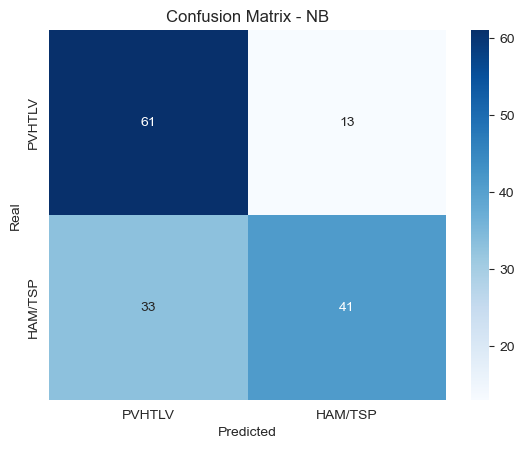

Predicted labels distribution for RF: [68 80]


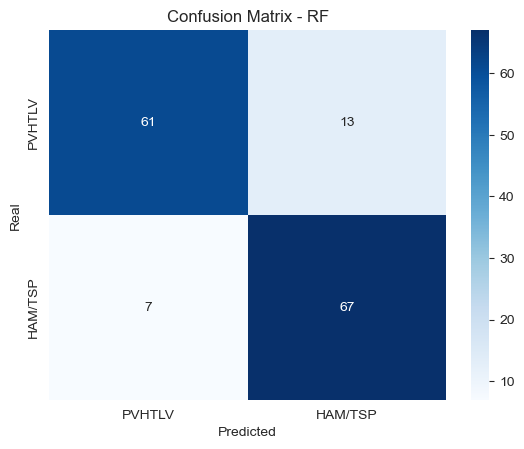

Predicted labels distribution for SVM: [73 75]


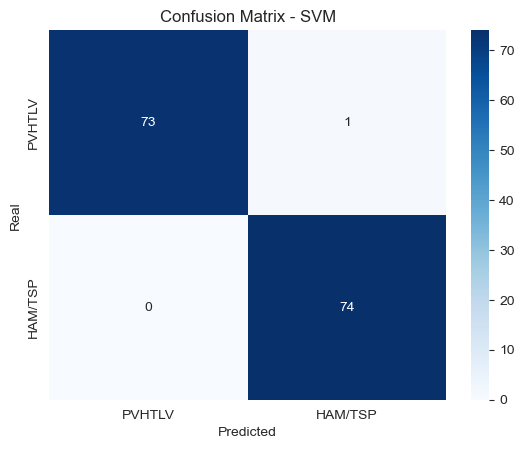

Predicted labels distribution for KNN: [73 75]


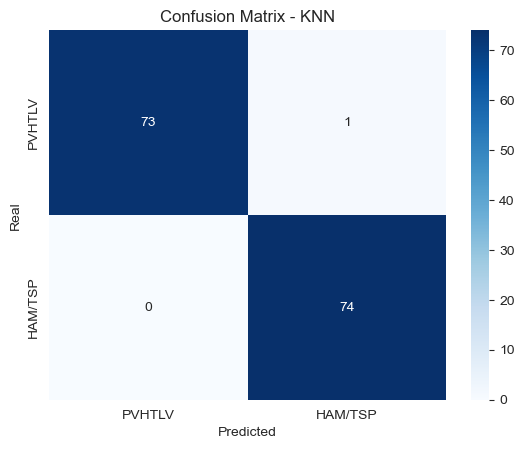

c:\Users\mathe\anaconda3\envs\ML-2024python3_11_\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Predicted labels distribution for AB: [73 75]


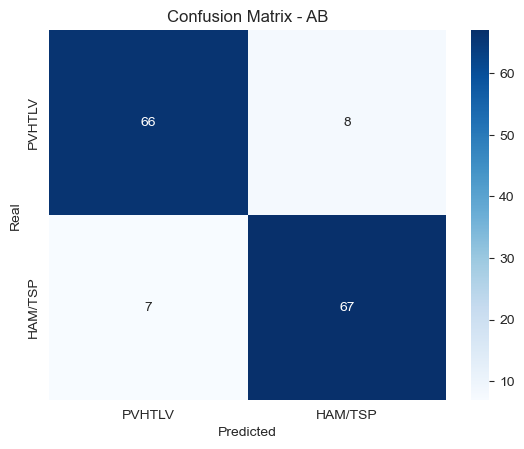

c:\Users\mathe\anaconda3\envs\ML-2024python3_11_\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Predicted labels distribution for LSVM: [92 56]


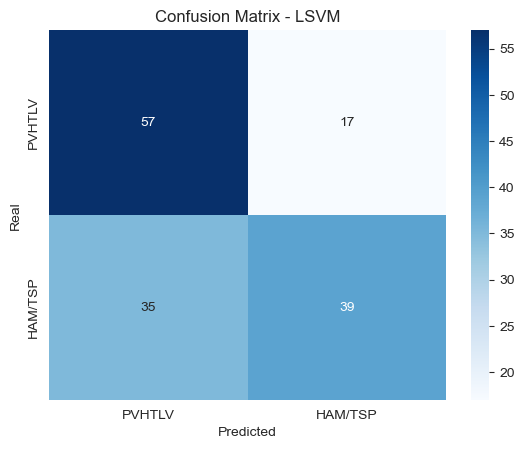

In [43]:
def plot_confusion_matrix(model_name):
    # Select the model
    model = classifiers[model_name]

    # Get the balancing method
    balancing_method = get_balancing_method()

    # Define the pipeline using the balancing method and the classifier
    pipeline = Pipeline([
        ('balancing', balancing_method),  # Balanceamento usando método selecionado
        ('classifier', model)  # Classificador
    ])
    
    # Fit the pipeline to the data
    pipeline.fit(X, y)
    
    # Resample the data using the balancing method
    X_res, y_res = balancing_method.fit_resample(X, y)
    
    # Make predictions on the resampled data
    y_preds = pipeline.predict(X_res)
    
    # Calculate the confusion matrix
    cm = confusion_matrix(y_res, y_preds) 
    
    # Print the predicted labels distribution for debugging
    print(f"Predicted labels distribution for {model_name}: {np.bincount(y_preds)}")
    
    # Define custom labels
    labels = ['PVHTLV', 'HAM/TSP']

    # Plot the heat map
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Real')
    plt.title(f'Confusion Matrix - {model_name}')
    
    # Save the picture
    #plt.savefig(f'../results/{model_name}_confusion_matrix.jpeg')
    plt.show()
# Iterating over each model in classifiers
for model_name in classifiers:
    plot_confusion_matrix(model_name)